In [1]:
from colabfit.tools.database import MongoDatabase, load_data
from colabfit.tools.property_settings import PropertySettings

client = MongoDatabase('colabfit_database', nprocs=1)

# Verifying dataset correctness

In [2]:
client.datasets.distinct('name')

[]

In [14]:
ds_id = client.datasets.find_one({'name': 'AlNiTi_CMS2019'})['_id']
dataset = client.get_dataset(ds_id)['dataset']
dataset.name, ds_id

('AlNiTi_CMS2019', '8781635671254906581')

In [13]:
client.plot_histograms(dataset.aggregated_info['property_fields'], ids=dataset.property_ids, yscale='log')

In [15]:
client.properties.find_one({'relationships.datasets': ds_id})

{'_id': '-8226399728652437602',
 'energy-forces-stress': {'energy': {'source-value': -4.940626021,
   'source-unit': 'eV'},
  'forces': {'source-value': [[1.9e-05, 1.9e-05, -0.215324],
    [-8e-06, -8e-06, 0.0001],
    [1.9e-05, 1.9e-05, 0.215789],
    [2.9e-05, 3e-05, 0.088232],
    [3.1e-05, 3e-05, 7.7e-05],
    [3e-05, 3e-05, -0.088776],
    [-2.8e-05, -2.9e-05, -0.236423],
    [-3e-05, -3.1e-05, 0.000987],
    [-3.2e-05, -2.9e-05, -0.001399],
    [-2.9e-05, -3.1e-05, 0.236736]],
   'source-unit': 'eV/Ang'},
  'stress': {'source-value': [[-0.58405, -0.0, -2e-05],
    [-0.0, -0.58403, -0.0],
    [-2e-05, -0.0, -2.78469]],
   'source-unit': 'GPa'}},
 'labels': [],
 'last_modified': '2021-12-21T15:47:09Z',
 'methods': ['VASP'],
 'relationships': {'configurations': ['6170079294091198669'],
  'property_settings': ['2231808486057270801'],
  'datasets': ['8781635671254906581']},
 'type': 'energy-forces-stress'}

# Number of configurations

In [2]:
client.configurations.count_documents({})

299570

# Number of properties

In [3]:
client.properties.count_documents({})

302231

# Number of datasets

In [4]:
client.datasets.count_documents({})

23

## Names of datasets

In [5]:
sorted(list(client.datasets.find({}, {'name'})), key=lambda x: x['name'].lower())

[{'_id': '8781635671254906581', 'name': 'AlNiTi_CMS2019'},
 {'_id': '6777652152778205123', 'name': 'basic_example'},
 {'_id': '7470401332738202221', 'name': 'basic_example_filtered'},
 {'_id': '-1762922854173037339', 'name': 'COMP6'},
 {'_id': '2417409142362287424', 'name': 'COMP6_filtered'},
 {'_id': '-2532936109959118574', 'name': 'CoNbV_CMS2019'},
 {'_id': '-9149414963510491212', 'name': 'CuPd_CMS2019'},
 {'_id': '9176260386122415846', 'name': 'InP_JPCA2020'},
 {'_id': '907174867108831874', 'name': 'Mo_PRM2019'},
 {'_id': '-8785508004041299947', 'name': 'MoNbTaVW_PRB2021'},
 {'_id': '-469750502015033977', 'name': 'Nb_PRM2019'},
 {'_id': '-825685447092694085', 'name': 'QM9'},
 {'_id': '-8632112835351781688', 'name': 'QM9_filtered'},
 {'_id': '8131394941117157318', 'name': 'Si_PRX_GAP'},
 {'_id': '2681402362852748630', 'name': 'Si_PRX_GAP-no-xc'},
 {'_id': '-908801678780544474', 'name': 'Si_PRX_GAP-pbe'},
 {'_id': '2089073070550352895', 'name': 'Si_PRX_GAP-pw91'},
 {'_id': '2966449356

# Number of configuration sets

In [6]:
client.configuration_sets.count_documents({})

263

## All configuration sets, and their linked datasets

In [7]:
cursor = client.configuration_sets.aggregate([
    {'$project': {'relationships.datasets': 1}},
    {'$unwind': '$relationships.datasets'},
    {'$project': {'ds_id': '$relationships.datasets'}},
    {'$lookup': {
        'from': 'datasets',
        'localField': 'ds_id',
        'foreignField': '_id',
        'as': 'linked_ds'
    }},
    {'$project': {'ds_name': '$linked_ds.name'}}
])

sorted(list(cursor), key=lambda x: x['ds_name'][0].lower())

[{'_id': '-3194719251435854557', 'ds_name': ['AlNiTi_CMS2019']},
 {'_id': '2611225195968150957', 'ds_name': ['AlNiTi_CMS2019']},
 {'_id': '-1456643302744194128', 'ds_name': ['AlNiTi_CMS2019']},
 {'_id': '4606653554654281923', 'ds_name': ['basic_example']},
 {'_id': '-6947816514471708576', 'ds_name': ['basic_example']},
 {'_id': '5034364161376630724', 'ds_name': ['basic_example_filtered']},
 {'_id': '7015075597653923489', 'ds_name': ['COMP6']},
 {'_id': '-6293489577227715767', 'ds_name': ['COMP6']},
 {'_id': '-1059182181057865827', 'ds_name': ['COMP6']},
 {'_id': '-7365321877405550115', 'ds_name': ['COMP6']},
 {'_id': '-9222624203333522011', 'ds_name': ['COMP6']},
 {'_id': '-2756663594895043175', 'ds_name': ['COMP6']},
 {'_id': '-6293489577227715767', 'ds_name': ['COMP6_filtered']},
 {'_id': '-1059182181057865827', 'ds_name': ['COMP6_filtered']},
 {'_id': '-7365321877405550115', 'ds_name': ['COMP6_filtered']},
 {'_id': '-9222624203333522011', 'ds_name': ['COMP6_filtered']},
 {'_id': '-2

## Configuration sets that are tied to more than one dataset

In [8]:
client.configuration_sets.count_documents({'relationships.datasets.1': {'$exists': True}})

22

In [9]:
cursor = client.configuration_sets.aggregate([
    {'$match': {'relationships.datasets.1': {'$exists': True}}},
    {'$project': {'relationships.datasets': 1}},
    {'$unwind': '$relationships.datasets'},
    {'$project': {'ds_id': '$relationships.datasets'}},
    {'$lookup': {
        'from': 'datasets',
        'localField': 'ds_id',
        'foreignField': '_id',
        'as': 'linked_ds'
    }},
    {'$project': {'ds_name': '$linked_ds.name'}}
])

list(cursor)

[{'_id': '-6293489577227715767', 'ds_name': ['COMP6']},
 {'_id': '-6293489577227715767', 'ds_name': ['COMP6_filtered']},
 {'_id': '-1059182181057865827', 'ds_name': ['COMP6']},
 {'_id': '-1059182181057865827', 'ds_name': ['COMP6_filtered']},
 {'_id': '-7365321877405550115', 'ds_name': ['COMP6']},
 {'_id': '-7365321877405550115', 'ds_name': ['COMP6_filtered']},
 {'_id': '-9222624203333522011', 'ds_name': ['COMP6']},
 {'_id': '-9222624203333522011', 'ds_name': ['COMP6_filtered']},
 {'_id': '-2756663594895043175', 'ds_name': ['COMP6']},
 {'_id': '-2756663594895043175', 'ds_name': ['COMP6_filtered']},
 {'_id': '5867373805259826', 'ds_name': ['QM9']},
 {'_id': '5867373805259826', 'ds_name': ['QM9_filtered']},
 {'_id': '3355647653253258362', 'ds_name': ['Si_PRX_GAP']},
 {'_id': '3355647653253258362', 'ds_name': ['Si_PRX_GAP-no-xc']},
 {'_id': '6324294746171141928', 'ds_name': ['Si_PRX_GAP']},
 {'_id': '6324294746171141928', 'ds_name': ['Si_PRX_GAP-no-xc']},
 {'_id': '-909176776488227328', 'd

# Total number of atoms

In [10]:
next(client.configurations.aggregate([
    {'$group': {'_id': None, 'sum': {'$sum': '$nsites'}}}
]))

{'_id': None, 'sum': 7017835}

# Total number of configuration labels

In [11]:
cursor = client.configurations.aggregate([
#     { "$match": { "_id": { "$in": [1, 2] } } },
    {"$group": {"_id": None, "labels": { "$push": "$labels" }}},
    {
        "$project": {
            "labels": {
                "$reduce": {
                    "input": "$labels",
                    "initialValue": [],
                    "in": { "$setUnion": ["$$value", "$$this"] }
                }
            }
        }
    }
])

labels = next(cursor)['labels']
len(labels)

49

## Counts for each label

In [12]:
cursor = client.configurations.aggregate([
    {'$unwind': '$labels'},
    {'$group': {'_id': '$labels', 'count': {'$sum': 1}}}
])

sorted(cursor, key=lambda x: x['count'], reverse=True)

[{'_id': 'bcc', 'count': 14906},
 {'_id': 'strain', 'count': 14576},
 {'_id': 'surface', 'count': 9123},
 {'_id': 'elastic', 'count': 8910},
 {'_id': 'gamma_surface', 'count': 7655},
 {'_id': 'active_learning', 'count': 7193},
 {'_id': 'aimd', 'count': 4550},
 {'_id': 'diamond', 'count': 1975},
 {'_id': 'eos', 'count': 1906},
 {'_id': 'vacancy', 'count': 1530},
 {'_id': 'interstitial', 'count': 1112},
 {'_id': 'random_data', 'count': 999},
 {'_id': 'sh', 'count': 889},
 {'_id': 'zincblende', 'count': 777},
 {'_id': 'repulsive', 'count': 756},
 {'_id': 'large_forces', 'count': 756},
 {'_id': 'warning', 'count': 756},
 {'_id': 'fcc', 'count': 689},
 {'_id': 'liquid', 'count': 612},
 {'_id': 'hcp', 'count': 549},
 {'_id': 'a15', 'count': 539},
 {'_id': 'c15', 'count': 500},
 {'_id': 'sc', 'count': 500},
 {'_id': 'a5', 'count': 445},
 {'_id': 'hea', 'count': 394},
 {'_id': 'divacancy', 'count': 242},
 {'_id': '111', 'count': 197},
 {'_id': 'dimer', 'count': 190},
 {'_id': 'sp', 'count': 18

# Property distributions

In [15]:
client.properties.find_one({})

{'_id': '-8226399728652437602',
 'energy-forces-stress': {'energy': {'source-value': -4.940626021,
   'source-unit': 'eV'},
  'forces': {'source-value': [[1.9e-05, 1.9e-05, -0.215324],
    [-8e-06, -8e-06, 0.0001],
    [1.9e-05, 1.9e-05, 0.215789],
    [2.9e-05, 3e-05, 0.088232],
    [3.1e-05, 3e-05, 7.7e-05],
    [3e-05, 3e-05, -0.088776],
    [-2.8e-05, -2.9e-05, -0.236423],
    [-3e-05, -3.1e-05, 0.000987],
    [-3.2e-05, -2.9e-05, -0.001399],
    [-2.9e-05, -3.1e-05, 0.236736]],
   'source-unit': 'eV/Ang'},
  'stress': {'source-value': [[-0.58405, -0.0, -2e-05],
    [-0.0, -0.58403, -0.0],
    [-2e-05, -0.0, -2.78469]],
   'source-unit': 'GPa'}},
 'labels': [],
 'last_modified': '2021-12-21T15:47:09Z',
 'methods': ['VASP'],
 'relationships': {'configurations': ['6170079294091198669'],
  'property_settings': ['2231808486057270801'],
  'datasets': ['8781635671254906581']},
 'type': 'energy-forces-stress'}

In [18]:
client.properties.distinct('type')

['comp6-data',
 'energy-forces',
 'energy-forces-stress',
 'energy-forces-virial',
 'qm9-property',
 'si-prx-gap-data']

In [39]:
all_energies = client.get_data('properties', ['energy-forces-stress.energy', 'energy-forces-virial.energy'], ravel=True, verbose=True)

Getting data: 302231it [00:01, 209075.96it/s]


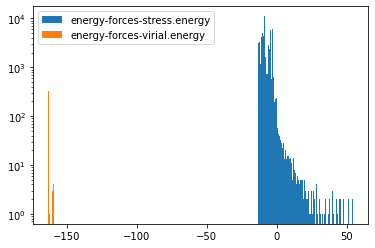

In [42]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()

for k,v in all_energies.items():        
    _ = ax.hist(v, bins=100, label=k)
    
ax.legend()
ax.set_yscale('log')

In [20]:
all_forces = client.get_data('properties', ['energy-forces-stress.forces', 'energy-forces-virial.forces'], ravel=True, verbose=True)

Getting data: 302231it [00:03, 79421.04it/s] 


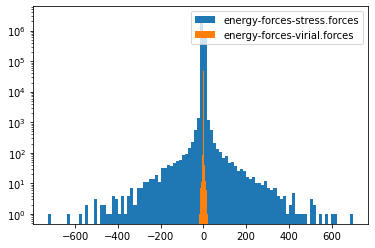

In [33]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()

for k,v in all_forces.items():
    _ = ax.hist(v, bins=100, label=k)
    
ax.legend()
ax.set_yscale('log')

In [43]:
all_stresses = client.get_data('properties', ['energy-forces-stress.stress', 'energy-forces-virial.virial'], ravel=True, verbose=True)

Getting data: 302231it [00:01, 169646.16it/s]


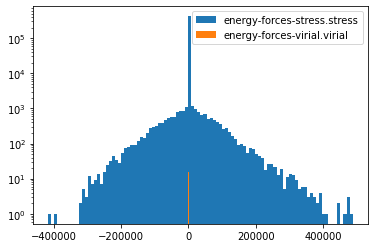

In [44]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()

for k,v in all_stresses.items():
    _ = ax.hist(v, bins=100, label=k)
    
ax.legend()
ax.set_yscale('log')

In [45]:
client.properties.distinct('energy-forces-stress.stress.source-unit')

['GPa']

In [46]:
client.properties.distinct('energy-forces-virial.virial.source-unit')

['GPa']

In [47]:
client.datasets.find_one({'name': 'WBe_PRB2019'})

{'_id': '-6889328512840717042',
 'aggregated_info': {'nconfigurations': 25055,
  'nsites': 524332,
  'nelements': 2,
  'chemical_systems': ['BeW', 'W', 'Be'],
  'elements': ['Be', 'W'],
  'individual_elements_ratios': {'Be': [0.67,
    1.0,
    0.75,
    0.5,
    0.92,
    0.09,
    0.14,
    0.01,
    0.04],
   'W': [0.33, 1.0, 0.99, 0.25, 0.5, 0.08, 0.91, 0.86, 0.96]},
  'total_elements_ratios': {'Be': 0.5016554396832541, 'W': 0.4983445603167459},
  'configuration_labels': ['aimd',
   'bcc',
   'elastic',
   'surface',
   'gamma_surface',
   'eos',
   'liquid',
   'dislocation',
   'divacancy',
   'stacking_fault'],
  'configuration_labels_counts': [4323,
   2129,
   8910,
   7203,
   6933,
   1638,
   75,
   98,
   38,
   5],
  'chemical_formula_reduced': ['Be3W32',
   'Be3W',
   'Be',
   'Be12W',
   'BeW6',
   'BeW',
   'BeW96',
   'Be2W',
   'W',
   'BeW24'],
  'chemical_formula_anonymous': ['A32B3',
   'A2B',
   'A96B',
   'A3B',
   'A6B',
   'A',
   'AB',
   'A12B',
   'A24B'],


In [48]:
client.properties.find_one({'relationships.datasets': '-6889328512840717042'})

{'_id': '-4511660976216482685',
 'energy-forces-stress': {'energy': {'source-value': -5.759970365,
   'source-unit': 'eV'},
  'forces': {'source-value': [[0.0, 0.0, 0.0], [0.0, 0.0, 0.0]],
   'source-unit': 'eV/Ang'},
  'stress': {'source-value': [[-32.31358, -3.89241, 42.06025],
    [-3.89241, -18.00726, 18.06758],
    [42.06025, 18.06758, -54.24125]],
   'source-unit': 'GPa'}},
 'labels': ['PBE', 'GGA'],
 'last_modified': '2021-12-21T16:21:31Z',
 'methods': ['VASP'],
 'relationships': {'configurations': ['9204710756730708066'],
  'property_settings': ['2231808486057270801'],
  'datasets': ['-6889328512840717042']},
 'type': 'energy-forces-stress'}